**Data Wrangling**


## PCA Code

In [1]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd

The following code wrangles the images, turning them into arrays, and loads them in as a dataset, simpsons_df, so that we can work with it in our project.

In [27]:
# import dataset

# import additional packages to process images as dataset
import os
from PIL import Image

# wrangle images and transform into arrays
def load_images_from_folder(folder_path, target_size=(75, 75), color_mode='RGB'):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load image
            img = Image.open(file_path).convert(color_mode)  # Convert to grayscale
            img = img.resize(target_size)  # Resize to target size
            images.append(np.array(img).flatten())  # Flatten to 1D array
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

# Load dataset
folder_path = "simpsons_faces_kostastokis/cropped"
simpsons_df = load_images_from_folder(folder_path, target_size=(200,200))

# Check the shape of the dataset
print(f"Dataset shape: {simpsons_df.shape}")


Dataset shape: (9877, 120000)


In [17]:
test_img = Image.open('simpsons_faces_kostastokis/cropped/437.png').convert('RGB').resize((75, 75))
print(np.array(test_img).shape)

(75, 75, 3)


In [28]:
def viewcolumn(columnvector):
    # viewcolumn(columnvector);
    # VIEWCOLUMN Displays a 60 x 60 grayscale image stored in a column vector.
    # Tim Marks 2002
    plt.imshow(columnvector.reshape((200, 200, 3), order='F').astype('uint8'))
    plt.title("Mean Image")
    plt.axis('off')
    plt.show()
    

def normc(Mat):
    # normc(M) normalizes the columns of M to a length of 1.
    return normalize(Mat, norm='l2', axis=0)

Compute & Display Mean Face:

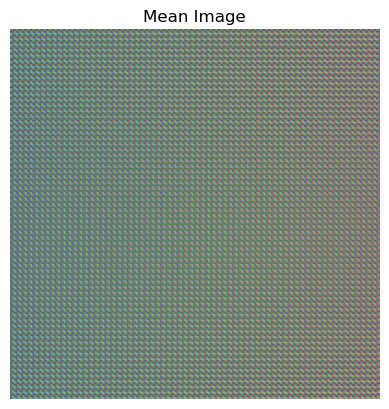

In [29]:
# find mean
mean_simp = np.mean(simpsons_df, axis=0)

# View a transformed version of mean

# since we are using RGB, there are 3 color channels, thus 75 x 75 x 3
mean_simp_view = mean_simp.reshape((200, 200, 3), order="F")
viewcolumn(mean_simp_view)

**PCA method #1**: Directly compute ATA and its eigenvectors

In [ ]:
# A = simpsons_df - mean_simp
    # Find eigenvectors & eigenvalues of ATA
# eigvals, V_old =np.linalg.eig(A.T.dot(A))
    # Sort the eigenvectors & eigenvalues from largest to smallest
# V, D = eigsort(V_old, eigvals)
    # calcualte the matrix of eigensimpsons, (the eigenvectors of AAT)
# U = A.dot(V)

    # normalize the columns of U (should all have length 1)
# U = normc(U)

In [ ]:
# Check that A, U, V, & D are looking as expected

# assert A.shape == 
# assert V.shape == 
# assert U.shape ... 
# check D, that diagonal matrix of eigenvalues are sorted from largest to smallest


In [ ]:
# function to reconstruct desired simpson image

def reconstruct_simp(i):
    # find pricipal compoents of image
    princ_comp = simpsons_df[i, :] - mean_simp
    c = U.T.dot(princ_comp)
    # reconstruct face using all principal components
    Zhat = U.dot(c) + mean_simp
    # reconstruct using just first 10 principal components
    Zhat_2 = U[:,:10].dot(c[:10,]) + mean_simp

    viewcolumn(Zhat.reshape((100,100), order='F'))
    viewcolumn(Zhat_2.reshape((100,100), order='F'))


I wrote the above code based on the code for HW4, but I think for our large dataset, as it was taking over an hour to run, and I did not even get to finish running it. We will need something more efficient, and something that only uses the most efficient/important principal components. Thus, maybe we discuss our understanding of above code, but ultimately have have to use a different method. 

**PCA method #2**: Singular Value Decomposition

In [22]:
A = simpsons_df - mean_simp

# Use SVD tp represent reduced-dimension subspace using following components:
    # U = left eigenvectors, 
    # S = sqrt of eigenvalues/diagonal values, 
    # Vt = transposed right singular vectors 
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Specify to keep only 50 top princial components that contribute most variation
k = 50
# top 50 eigensimpsons
Uk = U[:, :k]
Sk = S[:k]
Vtk = Vt[:k, :]

# get the reduced representation
Z = A.dot(Vtk.T)


In [23]:
# code for reconstruction

def reconstruct_simp_2(Z, i, Vtk, mean_simp):
    reconstructed_simp = Z[i, :].dot(Vtk) + mean_simp
    return reconstructed_simp

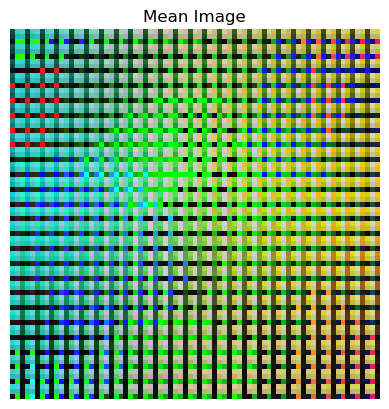

In [ ]:
# test and vizualize reconstructionl

reconstruct_first = reconstruct_simp_2(Z, 0, Vtk, mean_simp)
reconstruct_first_view = reconstruct_first.reshape((75, 75, 3), order="F")
viewcolumn(reconstruct_first_view)

In [26]:
# import dataset

# import additional packages to process images as dataset
import os
from PIL import Image

# wrangle images and transform into arrays
def load_images_from_folder(folder_path, target_size=(200, 200)):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load image
            img = Image.open(file_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to target size
            images.append(np.array(img).flatten())  # Flatten to 1D array
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

# Load dataset
folder_path = "simpsons_faces_kostastokis/cropped"
simpsons_df = load_images_from_folder(folder_path, target_size=(75,75))

# Check the shape of the dataset
print(f"Dataset shape: {simpsons_df.shape}")



Dataset shape: (9877, 5625)


In [ ]:
def viewcolumn(columnvector, image_size=(50, 50, 2), title="Image"):
    columnvector = columnvector.reshape(image_size)
    plt.imshow(columnvector, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    

def normc(Mat):
    # normc(M) normalizes the columns of M to a length of 1.
    return normalize(Mat, norm='l2', axis=0)

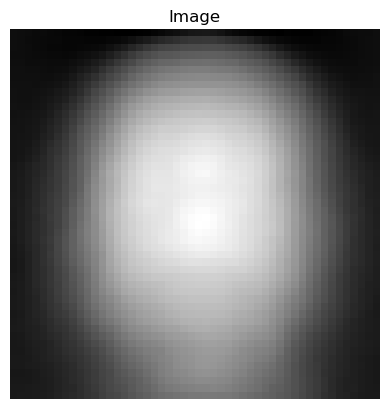

In [ ]:
# find mean
mean_simp = np.mean(simpsons_df, axis=0)

# View a transformed version of mean

mean_simp_view = mean_simp.reshape((50, 50, 3))
viewcolumn(mean_simp_view)

In [14]:
A = simpsons_df - mean_simp

# Use SVD tp represent reduced-dimension subspace using following components:
    # U = left eigenvectors, 
    # S = sqrt of eigenvalues/diagonal values, 
    # Vt = transposed right singular vectors 
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Specify to keep only 50 top princial components that contribute most variation
k = 50
# top 50 eigensimpsons
Uk = U[:, :k]
Sk = S[:k]
Vtk = Vt[:k, :]

# get the reduced representation
Z = A.dot(Vtk.T)


In [15]:
# code for reconstruction

def reconstruct_simp_2(Z, i, Vtk, mean_simp):
    reconstructed_simp = Z[i, :].dot(Vtk) + mean_simp
    return reconstructed_simp

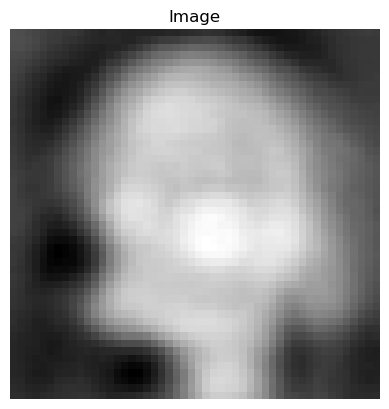

In [16]:
reconstruct_first = reconstruct_simp_2(Z, 0, Vtk, mean_simp)

reconstruct_first_view = reconstruct_first.reshape((50, 50))
viewcolumn(reconstruct_first_view)

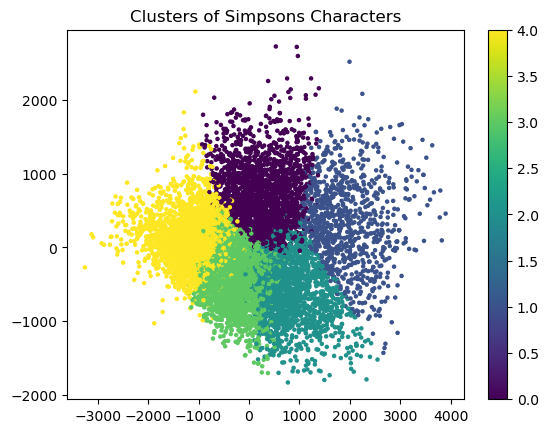

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)  
labels = kmeans.fit_predict(Z)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z)

plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Clusters of Simpsons Characters")
plt.colorbar()
plt.show()


In [40]:
cluster_labels = kmeans.labels_

clustered_data = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(Z.shape[1])])
clustered_data['Cluster'] = cluster_labels

cluster_means = clustered_data.groupby('Cluster').mean()

print(cluster_means.iloc[:, :5]) 


                 PC1         PC2         PC3         PC4        PC5
Cluster                                                            
0        -258.837292  708.452425   34.528596 -121.569409  83.035543
1       -1923.790275  351.995548   -4.465727   87.846669 -88.581490
2        -830.657446 -591.560305 -114.282904  147.372604 -49.962159
3         287.725692 -400.098137  148.594225 -174.907630  64.727496
4        1148.219315  101.593952  -95.931030  138.283180 -63.929879


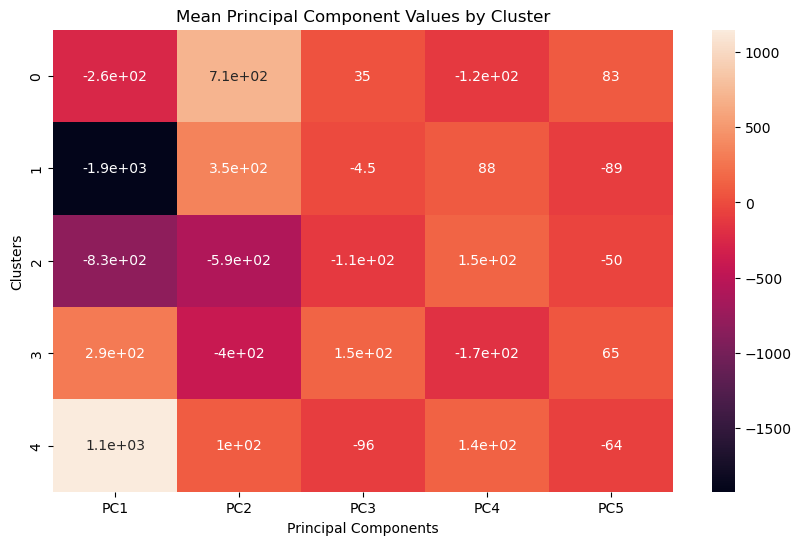

In [41]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.iloc[:, :5], annot=True)
plt.title("Mean Principal Component Values by Cluster")
plt.xlabel("Principal Components")
plt.ylabel("Clusters")
plt.show()


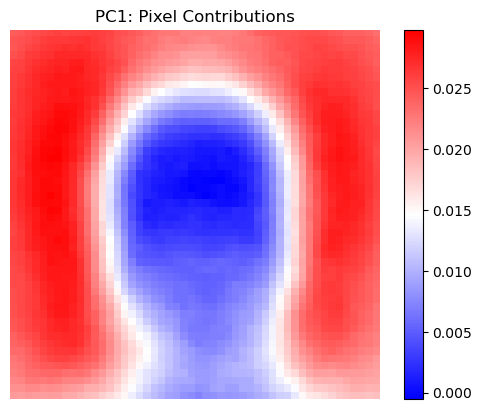

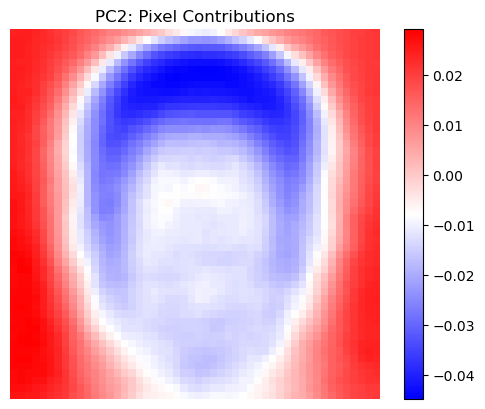

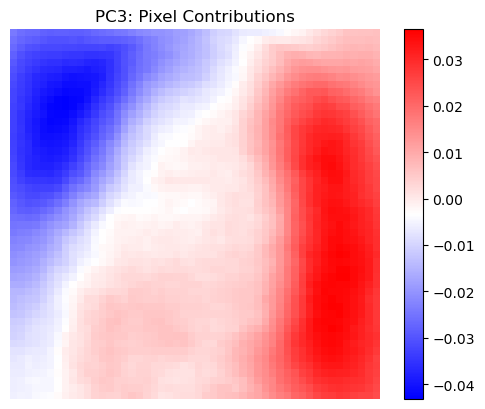

In [39]:
num_pcs_to_inspect = 3

for i in range(num_pcs_to_inspect):
    component = Vtk[i, :].reshape(50, 50)  
    plt.imshow(component, cmap='bwr')
    plt.title(f"PC{i+1}: Pixel Contributions")
    plt.colorbar()
    plt.axis('off')
    plt.show()


Cluster 0:


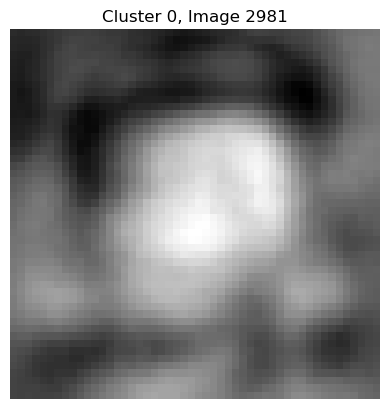

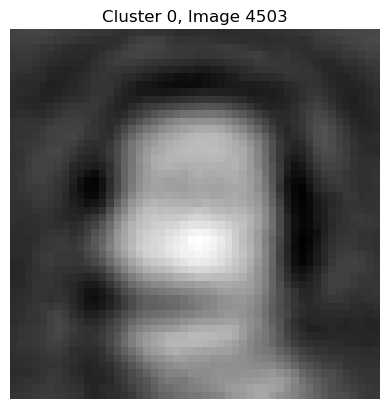

Cluster 1:


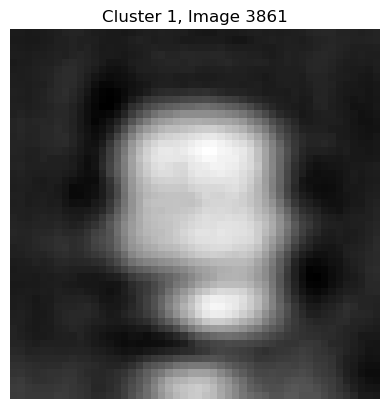

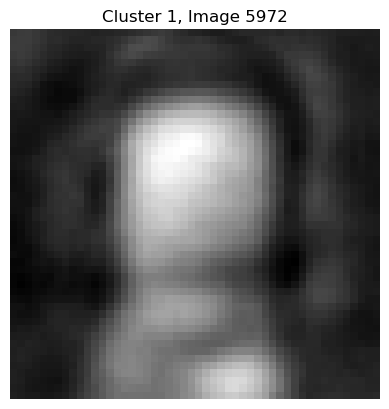

Cluster 2:


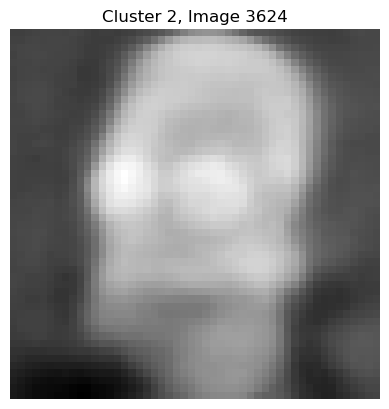

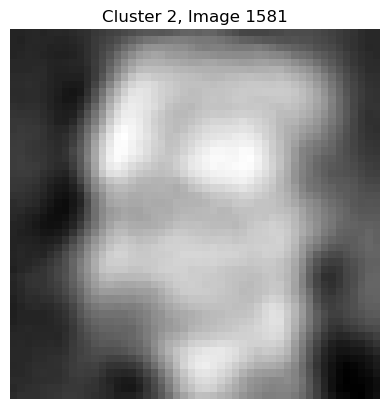

Cluster 3:


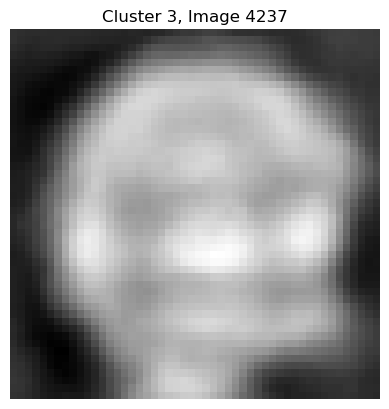

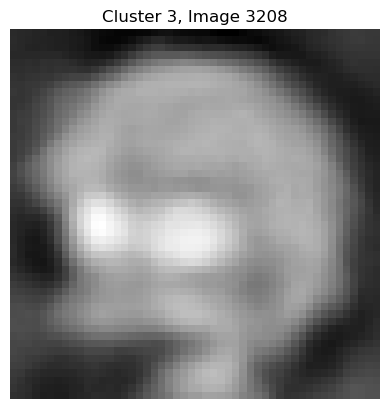

Cluster 4:


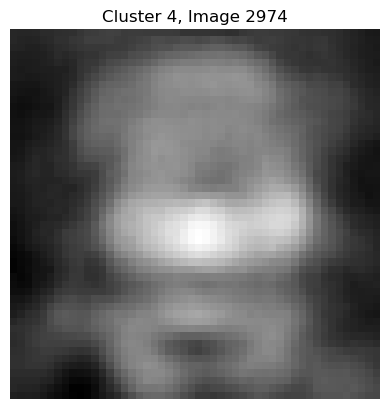

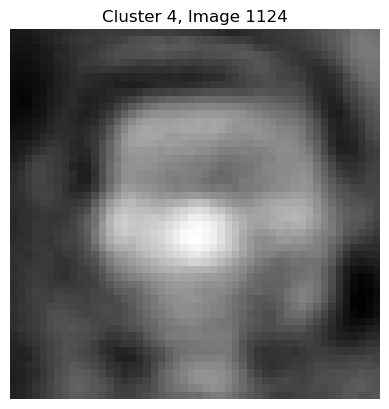

In [43]:
def find_representative_images(Z, cluster_labels, n_representatives=2):
    representatives = {}
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_points = Z[cluster_indices]
        cluster_center = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        representative_indices = cluster_indices[np.argsort(distances)[:n_representatives]]
        representatives[cluster] = representative_indices
    return representatives

representative_images = find_representative_images(Z, cluster_labels)

for cluster, indices in representative_images.items():
    print(f"Cluster {cluster}:")
    for idx in indices:
        reconstructed = reconstruct_simp_2(Z, idx, Vtk, mean_simp)
        plt.imshow(reconstructed.reshape(50, 50), cmap='gray')
        plt.title(f"Cluster {cluster}, Image {idx}")
        plt.axis('off')
        plt.show()


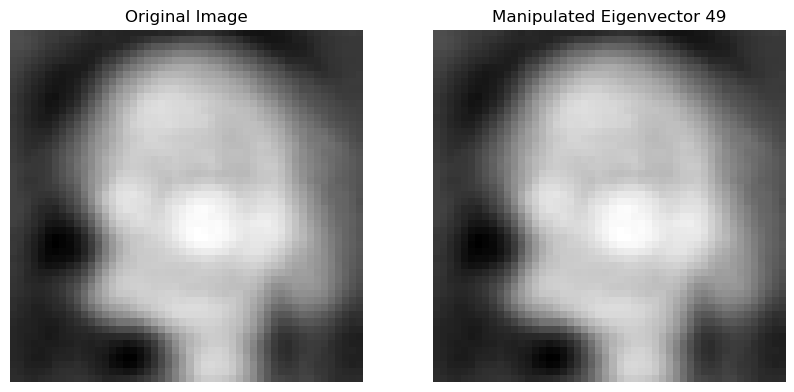

In [64]:
import matplotlib.pyplot as plt

def manipulate_eigenvector(i, factor, Vtk, mean_simp, Z, image_index=0):
    manipulated_Z = Z.copy()
    manipulated_Z[image_index, i] += factor
    
    original_image = Z[image_index, :] @ Vtk + mean_simp
    manipulated_image = manipulated_Z[image_index, :] @ Vtk + mean_simp
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    axes[0].imshow(original_image.reshape((50, 50)), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(manipulated_image.reshape((50, 50)), cmap='gray')
    axes[1].set_title(f"Manipulated Eigenvector {i}")
    axes[1].axis('off')
    
    plt.show()

manipulate_eigenvector(49, factor=1, Vtk=Vtk, mean_simp=mean_simp, Z=Z)


Code to perform reproduction:

**Test: Reconstruct each PCA model, then measure distance between reconstruction and input**

**Find & Discuss Lowest Distance**